In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

from transformers import DistilBertModel, DistilBertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_metric

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Hyperparams

In [3]:
epochs = 4
learning_rate = 2e-5
eps = 1e-7
batch_size = 32

# Load & preprocess data

In [4]:
df = pd.read_csv('data/archive/ner_dataset.csv', encoding="latin-1")

In [5]:
tag_encoder = LabelEncoder()
tag_encoder.fit(df['Tag']);

In [6]:
df['Sentence #'] = df['Sentence #'].fillna(method="ffill")
df['Tag_Encoded'] = tag_encoder.transform(df['Tag'])

sentences = df.groupby('Sentence #')["Word"].apply(list).values
tag_encoded = df.groupby('Sentence #')["Tag_Encoded"].apply(list).values

In [7]:
train_sentences, test_sentences, train_tag, test_tag = train_test_split(sentences, tag_encoded, test_size=0.3, random_state=2021)
test_sentences, valid_sentences, test_tag, valid_tag = train_test_split(test_sentences, test_tag, test_size=0.5, random_state=2021)

# Prepare dataset and loader

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [9]:
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        super(NERDataset, self).__init__()
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]
        
        tokenized_input = self.tokenizer(
            sentence, is_split_into_words=True, return_offsets_mapping=True, padding='max_length', truncation=True,
            return_tensors='pt', max_length=self.max_len
        )
        
        labels = []
        previous_word_idx = None
        label_all_tokens = True
        
        word_ids = tokenized_input.word_ids()
        
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(label[word_idx])
            else:
                labels.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
            
        return {
            'input_ids': tokenized_input['input_ids'].squeeze(0),
            'attention_mask': tokenized_input['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels)
        }

In [10]:
train_dataset = NERDataset(train_sentences, train_tag, tokenizer)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

valid_dataset = NERDataset(valid_sentences, valid_tag, tokenizer)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

# Build Model

In [11]:
class NERModel(nn.Module):
    def __init__(self):
        super(NERModel, self).__init__()
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-cased')
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(768, 256),
            nn.GELU(),
            nn.Linear(256, 17)
        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids, attention_mask)
        return self.classifier(outputs[0])

In [12]:
model = NERModel()
model.to('cuda');

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_dataloader))
criterion = nn.CrossEntropyLoss()

# Training Loop

In [14]:
metric = load_metric("seqeval")

In [15]:
label_list = tag_encoder.classes_.tolist()

In [16]:
def compute_metrics(preds, targets):
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    predictions = np.argmax(preds, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, targets)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, targets)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    
    return results

In [17]:
total_training_loss = []
total_validation_loss = []

total_training_metric = []
total_validation_metric = []

for epoch in tqdm(range(epochs)):
    model.train()
    training_loss = 0
    preds = []
    targets = []
    
    for step, train_data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        train_input_ids = train_data['input_ids'].to('cuda')
        train_attention_mask = train_data['attention_mask'].to('cuda')
        train_label = train_data['labels'].to('cuda')
        
        # Forward pass
        model.zero_grad()
        logits = model(train_input_ids, train_attention_mask)
        
        # Backward pass
        if train_attention_mask is not None:
            active_loss = train_attention_mask.view(-1) == 1
            active_logits = logits.view(-1, 17)
            active_labels = torch.where(
                active_loss, train_label.view(-1), 
                torch.tensor(criterion.ignore_index).type_as(train_label)
            )
            loss = criterion(active_logits, active_labels)
        else:
            loss = criterion(logits.view(-1, 17), train_label.view(-1))
            
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        training_loss += loss.item()
        
        preds.append(logits.detach().cpu().numpy())
        targets.append(train_label.detach().cpu().numpy())
        
        if step % 500 == 0 and step != 0:
            print('Current Loss: {}'.format(training_loss / len(train_dataloader)))
    
    results = compute_metrics(preds, targets)
    print('[Training Epoch %d]\nTraining loss: %.3f' %(epoch + 1, training_loss / len(train_dataloader)))
    print('\n[Training Metrics]')
    print('Precision: {}\nRecall: {}\nF1 Score: {}\nAcc: {}'.format(
        round(results['overall_precision'] * 100, 2),
        round(results['overall_recall'] * 100, 2),
        round(results['overall_f1'] * 100, 2),
        round(results['overall_accuracy'] * 100, 2)
    ))
    total_training_loss.append(training_loss / len(train_dataloader))
    total_training_metric.append(results)
    
    model.eval()
    validation_loss = 0
    preds = []
    targets = []
    for step, valid_data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
        valid_input_ids = valid_data['input_ids'].to('cuda')
        valid_attention_mask = valid_data['attention_mask'].to('cuda')
        valid_label = valid_data['labels'].to('cuda')
        
        with torch.no_grad():
            logits = model(valid_input_ids, valid_attention_mask)
            
        if valid_attention_mask is not None:
            active_loss = valid_attention_mask.view(-1) == 1
            active_logits = logits.view(-1, 17)
            active_labels = torch.where(
                active_loss, valid_label.view(-1), 
                torch.tensor(criterion.ignore_index).type_as(valid_label)
            )
            loss = criterion(active_logits, active_labels)
        else:
            loss = criterion(logits.view(-1, 17), train_label.view(-1))
        
        validation_loss += loss.item()
        
        preds.append(logits.detach().cpu().numpy())
        targets.append(valid_label.detach().cpu().numpy())
    
    results = compute_metrics(preds, targets)
    print('[Validation Epoch %d]\nValidation loss: %.3f' %(epoch + 1, validation_loss / len(valid_dataloader)))
    print('\n[Validation Metrics]')
    print('Precision: {}\nRecall: {}\nF1 Score: {}\nAcc: {}'.format(
        round(results['overall_precision'] * 100, 2),
        round(results['overall_recall'] * 100, 2),
        round(results['overall_f1'] * 100, 2),
        round(results['overall_accuracy'] * 100, 2)
    ))
    total_validation_loss.append(validation_loss / len(valid_dataloader))
    total_validation_metric.append(results)

Current Loss: 0.19346215570256822
Current Loss: 0.27303150238735335

[Training Epoch 1] Training loss: 0.280
[Training Metrics]
Precision: 70.52
Recall: 67.65
F1 Score: 69.05
Acc: 93.01


/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Validation Epoch 1]
Validation loss: 0.148
[Validation Metrics]
Precision: 79.88
Recall: 79.96
F1 Score: 79.92
Acc: 95.59


Current Loss: 0.06484471455925987
Current Loss: 0.12701310107750552

[Training Epoch 2] Training loss: 0.133
[Training Metrics]
Precision: 81.37
Recall: 81.29
F1 Score: 81.33
Acc: 96.0



[Validation Epoch 2]
Validation loss: 0.136
[Validation Metrics]
Precision: 81.36
Recall: 80.85
F1 Score: 81.1
Acc: 95.85


Current Loss: 0.053035764158481644
Current Loss: 0.10351296813715072

[Training Epoch 3] Training loss: 0.108
[Training Metrics]
Precision: 84.01
Recall: 83.91
F1 Score: 83.96
Acc: 96.66



[Validation Epoch 3]
Validation loss: 0.131
[Validation Metrics]
Precision: 81.89
Recall: 82.06
F1 Score: 81.98
Acc: 95.95


Current Loss: 0.04539779390784956
Current Loss: 0.08940536488202357

[Training Epoch 4] Training loss: 0.094
[Training Metrics]
Precision: 85.92
Recall: 85.62
F1 Score: 85.77
Acc: 97.09



[Validation Epoch 4]
Validation loss: 0.131
[Validation Metrics]
Precision: 81.86
Recall: 82.12
F1 Score: 81.99
Acc: 95.98



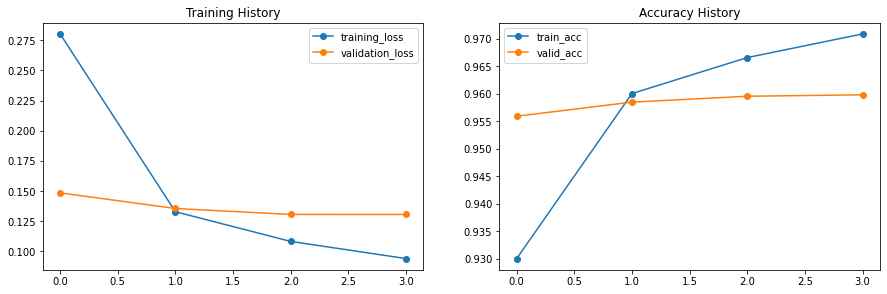

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Training History')
plt.plot(total_training_loss, '-o', label='training_loss')
plt.plot(total_validation_loss, '-o', label='validation_loss')
plt.legend();

plt.subplot(222)
plt.title('Accuracy History')
train_acc = [metric['overall_accuracy'] for metric in total_training_metric]
valid_acc = [metric['overall_accuracy'] for metric in total_validation_metric]
plt.plot(train_acc, '-o', label='train_acc')
plt.plot(valid_acc, '-o', label='valid_acc')
plt.legend();

# Model Evaluation

In [21]:
test_dataset = NERDataset(test_sentences, test_tag, tokenizer)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

In [24]:
preds = []
targets = []
for test_data in tqdm(test_dataloader, total=len(test_dataloader)):
    test_input_ids = test_data['input_ids'].to('cuda')
    test_attention_mask = test_data['attention_mask'].to('cuda')
    test_label = test_data['labels']

    with torch.no_grad():
        logits = model(test_input_ids, test_attention_mask)
        
    preds.append(logits.detach().cpu().numpy())
    targets.append(test_label.detach().cpu().numpy())

In [26]:
results = compute_metrics(preds, targets)
results

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'art': {'precision': 0.5,
  'recall': 0.043010752688172046,
  'f1': 0.07920792079207922,
  'number': 93},
 'eve': {'precision': 0.7647058823529411,
  'recall': 0.2653061224489796,
  'f1': 0.3939393939393939,
  'number': 49},
 'geo': {'precision': 0.8412102243088159,
  'recall': 0.8971848225214198,
  'f1': 0.8682963601119965,
  'number': 8987},
 'gpe': {'precision': 0.95427059712774,
  'recall': 0.9195193008011653,
  'f1': 0.9365727002967358,
  'number': 2746},
 'nat': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 38},
 'org': {'precision': 0.7355599214145383,
  'recall': 0.7076167076167076,
  'f1': 0.7213177921202195,
  'number': 5291},
 'per': {'precision': 0.7926944971537002,
  'recall': 0.7902577441475526,
  'f1': 0.791474245115453,
  'number': 4229},
 'tim': {'precision': 0.8674968071519795,
  'recall': 0.8329245861434703,
  'f1': 0.8498592430403502,
  'number': 3262},
 'overall_precision': 0.8264355713938608,
 'overall_recall': 0.8264021056894109,
 'overall_f1': 0.826418

# Model inference

In [89]:
test_set = list(zip(test_sentences, test_tag))

In [110]:
selected_choice = np.random.choice(len(test_set))

In [111]:
tokenized_input = tokenizer(
    test_set[selected_choice][0], is_split_into_words=True, return_offsets_mapping=True, padding='max_length', truncation=True,
    return_tensors='pt', max_length=128
)

In [112]:
preds = model(tokenized_input['input_ids'].to('cuda'), tokenized_input['attention_mask'].to('cuda'))
preds = preds.squeeze(0).detach().cpu().numpy()
true_labels = [label_list[label] for label in test_set[selected_choice][1]]
predictions = np.argmax(preds, axis=1)
preds_labels = [label_list[p] for index, (p, l) in enumerate(zip(predictions, true_labels)) if index !=0 or index == len(list(zip(predictions, true_labels)))]

In [113]:
print('Sent: {}\n\nGT: {}\n\nPRED: {}'.format(test_set[selected_choice][0], true_labels, preds_labels))

Sent: ['The', 'militants', 'were', 'trying', 'to', 'take', 'it', 'back', ',', 'but', 'government', 'commanders', 'said', 'Friday', 'they', 'had', 'been', 'driven', 'off', '.']

GT: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O']

PRED: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O']
